# 🌸 Iris Dataset Exploration

This notebook accompanies my first classification project with **Iris flowers**.  
Here I want to show how I explored the data, trained a basic model, tested an alternative, and saved the model for later use.

**Goals:**
- Understand the dataset and its features.
- Train a baseline model (Logistic Regression).
- Try an alternative model (KNN).
- Analyze errors with visualizations.
- Save and load the trained model, the same way I do in my `src/` scripts.


In [13]:
# 0) SETUP
# Import libraries and set a seed so results are reproducible.
import sys, pathlib, warnings, numpy as np
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set()
plt.rcParams['figure.dpi'] = 110  # clearer plots

SEED = 42
np.random.seed(SEED)  # reproducibility

# Access constants defined in src/common.py
ROOT = pathlib.Path().resolve().parent
SRC  = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

from common import FEATURE_COLUMNS, MODEL_PATH

print("Columns:", FEATURE_COLUMNS)
print("Model path:", MODEL_PATH)


Columns: ['sepal_length (cm)', 'sepal_width (cm)', 'petal_length (cm)', 'petal_width (cm)']
Model path: models/model.joblib


## 1. Load dataset

The Iris dataset comes built into `sklearn`. I convert it to a DataFrame for easier handling.


In [14]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=FEATURE_COLUMNS)
df['species'] = iris.target
target_names = iris.target_names

# show first rows
display(df.head())


,sepal_length (cm),sepal_width (cm),petal_length (cm),petal_width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 2. Statistics and class balance


In [15]:
# summary stats + missing values
stats = df[FEATURE_COLUMNS].describe().T
stats['missing'] = df[FEATURE_COLUMNS].isna().sum()
display(stats)

# number of samples per class
counts = df['species'].value_counts().sort_index()
display(pd.DataFrame({'species': target_names, 'count': counts.values}))


,count,mean,std,min,25%,50%,75%,max,missing
sepal_length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9,0
sepal_width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4,0
petal_length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9,0
petal_width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5,0


,species,count
0,setosa,50
1,versicolor,50
2,virginica,50


## 3. Data exploration (EDA)

I want to check how well the classes separate with some simple plots.


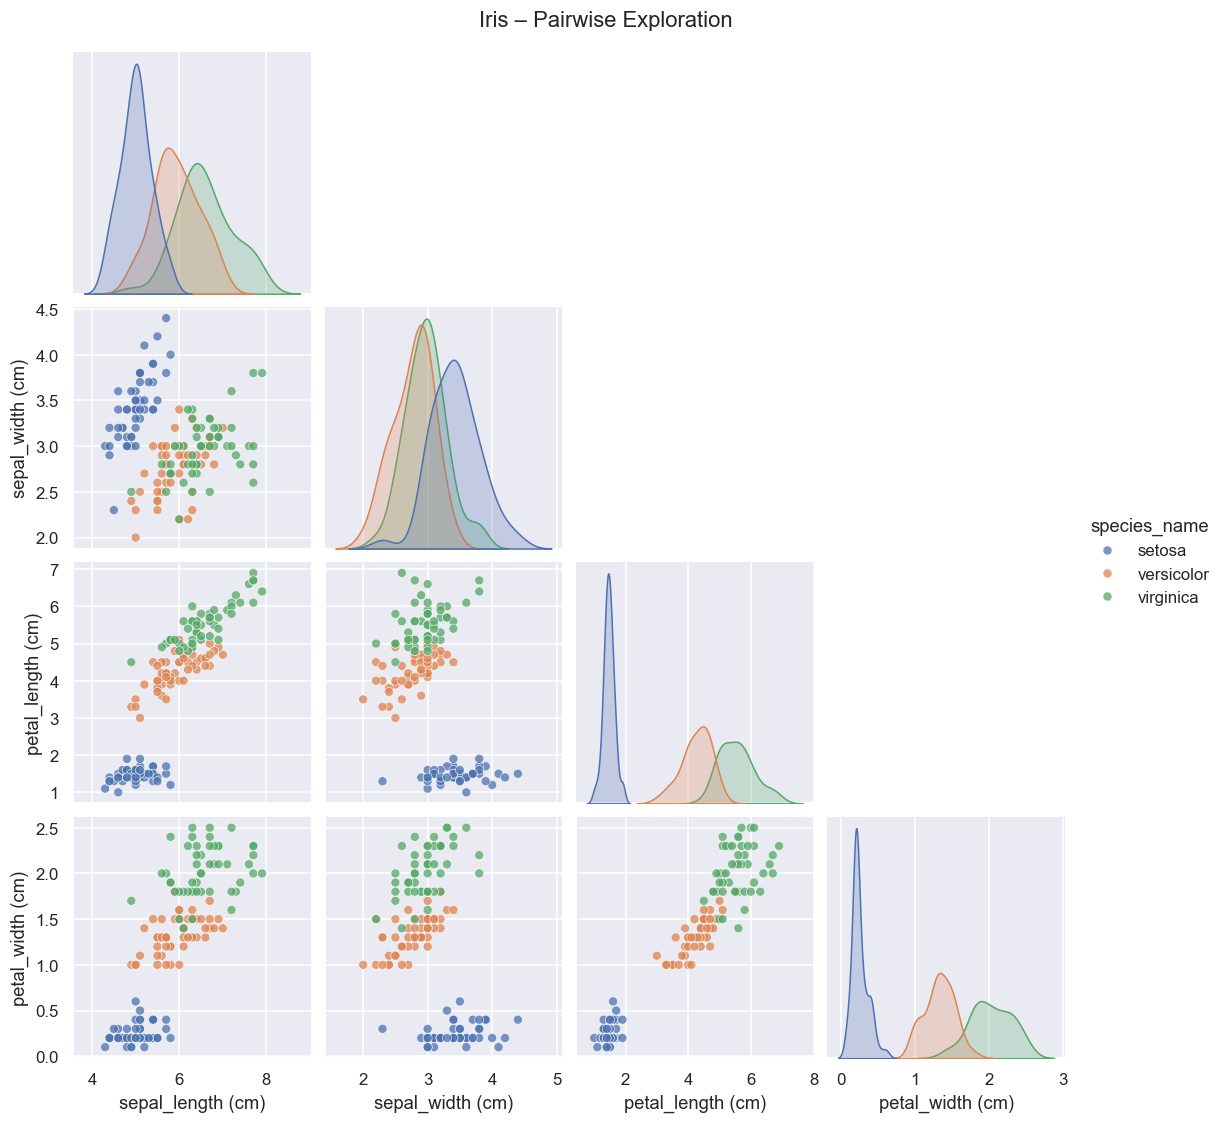

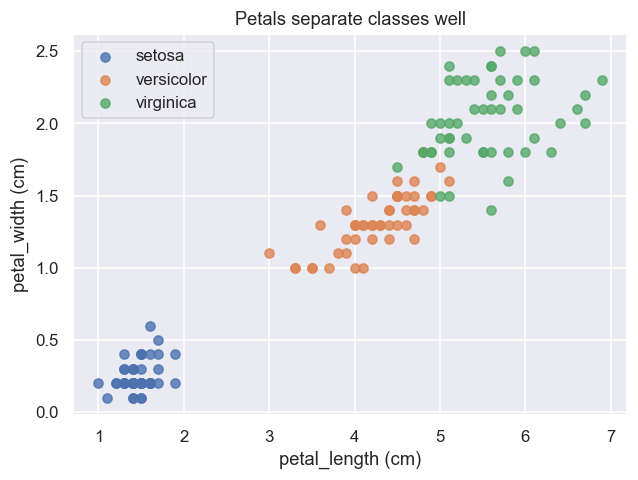

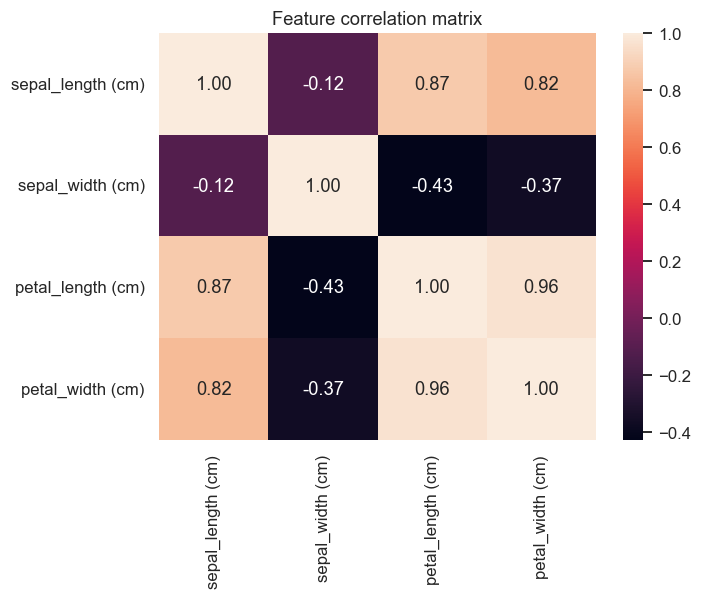

In [16]:
# pairplot to see feature distributions and separation
sns.pairplot(
    df.assign(species_name=df['species'].map(dict(enumerate(target_names)))),
    vars=FEATURE_COLUMNS, hue='species_name', corner=True,
    plot_kws={'alpha':0.75, 's':35}
)
plt.suptitle("Iris – Pairwise Exploration", y=1.02)
plt.show()

# scatter plot of petals (they separate classes more clearly)
plt.figure(figsize=(6.5, 4.5))
for k, name in enumerate(target_names):
    subset = df[df['species'] == k]
    plt.scatter(subset['petal_length (cm)'], subset['petal_width (cm)'], label=name, alpha=0.8)
plt.xlabel('petal_length (cm)')
plt.ylabel('petal_width (cm)')
plt.title("Petals separate classes well")
plt.legend()
plt.show()

# feature correlation
sns.heatmap(df[FEATURE_COLUMNS].corr(), annot=True, fmt='.2f')
plt.title("Feature correlation matrix")
plt.show()


## 4. Train/Test split

I split the dataset into training and testing sets.  
I use `stratify=y` so the class proportions are preserved.


In [17]:
from sklearn.model_selection import train_test_split

X = df[FEATURE_COLUMNS]
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train.shape, X_test.shape


((120, 4), (30, 4))

## 5. Baseline: Logistic Regression

Here I use a `Pipeline` with scaling to show a best practice.  
In `train.py` I left the simpler direct Logistic Regression model.


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.9333333333333333

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



### Confusion matrix
This helps me see where the model is making mistakes.


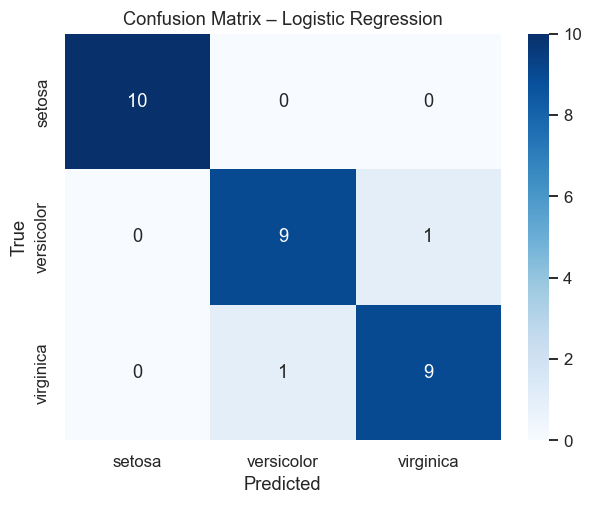

True: setosa  ->  Pred: {np.str_('setosa'): np.int64(10), np.str_('versicolor'): np.int64(0), np.str_('virginica'): np.int64(0)}
True: versicolor  ->  Pred: {np.str_('setosa'): np.int64(0), np.str_('versicolor'): np.int64(9), np.str_('virginica'): np.int64(1)}
True: virginica  ->  Pred: {np.str_('setosa'): np.int64(0), np.str_('versicolor'): np.int64(1), np.str_('virginica'): np.int64(9)}


In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix – Logistic Regression')
plt.ylabel("True"); plt.xlabel("Predicted")
plt.show()

# friendly row-by-row view
for i in range(3):
    row = cm[i]
    print(f"True: {target_names[i]}  ->  Pred: {dict(zip(target_names, row))}")


## 6. Compare with KNN

Trying another model helps confirm the dataset is easy to separate.


In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred))
print("Accuracy KNN:", accuracy_score(y_test, y_knn))


Accuracy Logistic Regression: 0.9333333333333333
Accuracy KNN: 1.0


## 7. Save and load the model

I save the **pipeline** so preprocessing + model can be reused exactly the same way.  
Then I load it and make a test prediction.


In [21]:
import pathlib

pathlib.Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
bundle = {"model": pipe_lr, "target_names": target_names}
joblib.dump(bundle, MODEL_PATH)
print("Model saved at:", MODEL_PATH)

# load and test
loaded = joblib.load(MODEL_PATH)
clf   = loaded["model"]
names = loaded["target_names"]

example = [5.1, 3.5, 1.4, 0.2]
pred   = int(clf.predict(pd.DataFrame([example], columns=FEATURE_COLUMNS))[0])
print("Input:", example)
print("Predicted species:", names[pred])


Model saved at: models/model.joblib
Input: [5.1, 3.5, 1.4, 0.2]
Predicted species: setosa


## 8. Reproducibility

I print library versions so results can be replicated in another environment.


In [23]:
import sklearn, platform
print("Python:", sys.version.split()[0])
print("scikit-learn:", sklearn.__version__)
print("Platform:", platform.platform())


Python: 3.13.7
scikit-learn: 1.7.2
Platform: macOS-15.6.1-arm64-arm-64bit-Mach-O


## 9. Conclusions

- **Petals** are better at separating classes than sepals (as seen in pairplot and scatter).  
- **Logistic Regression** already achieves very high accuracy.  
- **KNN** also works well, confirming this dataset is easy to classify.  
- Saving the full **pipeline** makes it reusable directly in my scripts.  
- Next steps I’d like to try:
  - Cross-validation and hyperparameter tuning.
  - Writing a short “model card” in the README (data, intended use, limitations).
  - (Optional) Serving a simple FastAPI endpoint for demo predictions.  
